Installing ortools ...
If in Colab: upload OptimizationProblemData.json now (or cancel to use the embedded example).


Requesting OSRM table (road distances)...
Received OSRM matrix.

Graph diagnostic:
 Nodes: 6  Edges: 30

Adjacency (distance in km) DataFrame:
           H      DT      GR      R2    R3_2      IT
H      0.000   8.628  11.496   9.445  10.852   9.672
DT    14.194   0.000   2.361  10.922   9.238   9.430
GR    17.785   7.745   0.000  11.808  10.124  10.478
R2    11.864  19.672  15.661   0.000  11.572  11.538
R3_2   7.343  12.172  10.053   4.071   0.000   5.931
IT     9.269   9.398  12.266   7.318   8.725   0.000

Visualizing ALL directed edges on the graph (may be dense).


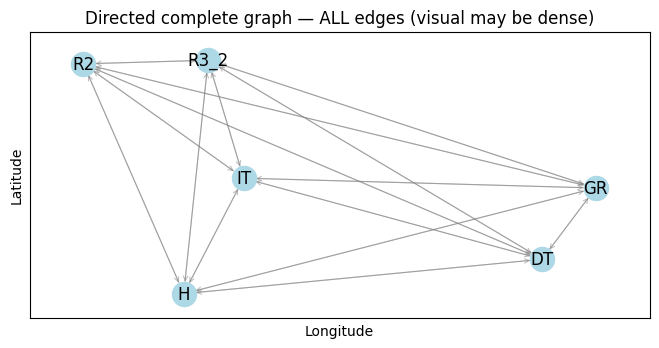


10 shortest directed edges (a -> b : km):
 DT -> GR : 2.361 km
 R3_2 -> R2 : 4.071 km
 R3_2 -> IT : 5.931 km
 IT -> R2 : 7.318 km
 R3_2 -> H : 7.343 km
 GR -> DT : 7.745 km
 H -> DT : 8.629 km
 IT -> R3_2 : 8.725 km
 DT -> R3_2 : 9.238 km
 IT -> H : 9.269 km
Running brute-force exact ...
Running A* ...
Running OR-Tools (CP-SAT) ...
Running Greedy Heuristic ...

--- Detailed results list for all tested algorithms ---
1. bruteforce : total_distance = 57.311100 km | exec_time = 0.0003 s
2. astar      : total_distance = 57.311100 km | exec_time = 0.0004 s
3. ortools    : total_distance = 57.311100 km | exec_time = 0.0107 s
4. heuristic  : total_distance = 57.311100 km | exec_time = 0.0001 s

Selected best algorithm: heuristic (distance=57.311100 km, time=0.0001 s)

Building map and fetching route geometry for visualization (distances used above are road distances).
Map saved to best_trips_map.html. In a notebook the map object 'm' will also render below (if supported).

--- Best trips (vi

In [ ]:
# --------------------------------------------------------------------------------
# The graph (directed complete) is created BEFORE solving.
# --------------------------------------------------------------------------------

import sys, subprocess, json, io, time, os, itertools, heapq, random, math
from math import isfinite
# ensure packages needed for graphing are available
def ensure_packages(pkgs):
    import importlib
    for pkg in pkgs:
        try:
            importlib.import_module(pkg)
        except Exception:
            print(f"Installing {pkg} ...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
ensure_packages(["requests","folium","ortools","networkx","matplotlib","pandas"])

import requests, folium, networkx as nx, pandas as pd, matplotlib.pyplot as plt
from folium import Popup
from ortools.sat.python import cp_model

# -------------------------
# Load problem JSON (Colab upload optional)
# -------------------------
data = None
try:
    from google.colab import files
    print("If in Colab: upload OptimizationProblemData.json now (or cancel to use the embedded example).")
    uploaded = files.upload()
    if uploaded:
        fname = list(uploaded.keys())[0]
        data = json.load(io.BytesIO(uploaded[fname]))
except Exception:
    uploaded = {}

if not data:
    # Embedded example
    data = {
      "problem_description": {
        "title": "Emergency Patient Transportation System",
        "objective": "Minimize total distance traveled while transporting all patients to hospital",
        "constraints": {"vehicles":1,"capacity_per_stop":1,"stops_per_trip":3,"total_patients":5}
      },
      "locations": {
        "hospital": {"name":"Central Hospital","coordinates":{"latitude":29.99512653425452,"longitude":31.68462840171934}},
        "patients": [
          { "id":"DT","name":"Patient DT","coordinates":{"latitude":30.000417586266437,"longitude":31.73960813272627} },
          { "id":"GR","name":"Patient GR","coordinates":{"latitude":30.011344405285193,"longitude":31.747827362371993} },
          { "id":"R2","name":"Patient R2","coordinates":{"latitude":30.030388325206854,"longitude":31.669231198639675} },
          { "id":"R3_2","name":"Patient R3_2","coordinates":{"latitude":30.030940768851426,"longitude":31.688371339937028} },
          { "id":"IT","name":"Patient IT","coordinates":{"latitude":30.01285635906825,"longitude":31.693811715848444} }
        ]
      }
    }

hospital = data["locations"]["hospital"]["coordinates"]
patients = data["locations"]["patients"]
ids = [p["id"] for p in patients]
coord_map = {"H": (hospital["latitude"], hospital["longitude"])}
for p in patients:
    coord_map[p["id"]] = (p["coordinates"]["latitude"], p["coordinates"]["longitude"])

# -------------------------
# OSRM & ORS matrix helpers (road distances)
# -------------------------
def to_lonlat_list(keys):
    return [(coord_map[k][1], coord_map[k][0]) for k in keys]  # (lon, lat)

def fetch_osrm_table_matrix(keys, timeout=20):
    coords = to_lonlat_list(keys)
    coord_str = ";".join(f"{lon:.6f},{lat:.6f}" for lon, lat in coords)
    url = f"http://router.project-osrm.org/table/v1/driving/{coord_str}?annotations=distance"
    r = requests.get(url, timeout=timeout)
    if r.status_code != 200:
        raise RuntimeError(f"OSRM table failed: status {r.status_code} | {r.text[:200]}")
    js = r.json()
    if "distances" not in js:
        raise RuntimeError("OSRM response missing 'distances'")
    mat_m = js["distances"]
    return [[(v/1000.0 if v is not None else None) for v in row] for row in mat_m]

def fetch_ors_matrix(keys, api_key, timeout=30):
    coords = to_lonlat_list(keys)
    url = "https://api.openrouteservice.org/v2/matrix/driving-car"
    headers = {"Authorization": api_key, "Content-Type": "application/json"}
    body = {"locations": coords, "metrics": ["distance"], "units": "m"}
    r = requests.post(url, headers=headers, json=body, timeout=timeout)
    if r.status_code != 200:
        raise RuntimeError(f"ORS matrix failed: status {r.status_code} | {r.text[:200]}")
    js = r.json()
    if "distances" not in js:
        raise RuntimeError("ORS response missing 'distances'")
    mat_m = js["distances"]
    return [[(v/1000.0 if v is not None else None) for v in row] for row in mat_m]

def build_road_distance_matrix(require_all_routable=True, try_ors_if_osrm_incomplete=True, ors_api_key=None):
    points = ["H"] + ids
    api_mat = None
    last_exc = None
    try:
        print("Requesting OSRM table (road distances)...")
        api_mat = fetch_osrm_table_matrix(points)
        print("Received OSRM matrix.")
    except Exception as e:
        api_mat = None
        last_exc = e
        print("OSRM table request failed:", e)

    need_ors = False
    if api_mat is not None:
        any_none = any(api_mat[i][j] is None for i in range(len(points)) for j in range(len(points)))
        if any_none:
            print("OSRM matrix contains unreachable entries (None).")
            need_ors = True
    else:
        need_ors = True

    api_mat_final = None
    if not need_ors:
        api_mat_final = api_mat
    else:
        if try_ors_if_osrm_incomplete and ors_api_key:
            try:
                print("Attempting OpenRouteService matrix (using provided ORS_API_KEY)...")
                ors_mat = fetch_ors_matrix(points, ors_api_key)
                print("Received ORS matrix.")
                if any(ors_mat[i][j] is None for i in range(len(points)) for j in range(len(points))):
                    print("ORS matrix still contains unreachable entries.")
                    api_mat_final = None
                else:
                    api_mat_final = ors_mat
            except Exception as e:
                last_exc = e
                print("ORS matrix request failed:", e)
                api_mat_final = None
        else:
            api_mat_final = None

    if api_mat_final is None:
        raise RuntimeError("Unable to obtain a complete road-distance matrix from OSRM or ORS. "
                           "Provide routable coordinates or set ORS_API_KEY env var for OpenRouteService fallback.")

    dist = {}
    points = ["H"] + ids
    for i, a in enumerate(points):
        dist[a] = {}
        for j, b in enumerate(points):
            v = api_mat_final[i][j]
            if v is None:
                raise RuntimeError(f"Unroutable pair detected for {a} -> {b} in final matrix.")
            dist[a][b] = float(v)
    return dist

# Optionally set ORS API key via environment variable ORS_API_KEY
ORS_API_KEY = os.environ.get("ORS_API_KEY")  # set this if you have ORS API key
dist = build_road_distance_matrix(require_all_routable=True, try_ors_if_osrm_incomplete=True, ors_api_key=ORS_API_KEY)

# -------------------------
# Build directed complete graph representing ALL ordered pairs (bidirectional)
# This represents the full state of pairwise travel cost "to and from" between nodes.
# -------------------------
points = ["H"] + ids
G = nx.DiGraph()
# add nodes with coordinates and label
for n in points:
    lat, lon = coord_map[n]
    G.add_node(n, latitude=lat, longitude=lon, label=(n if n!="H" else "Hospital"))

# add edges for every ordered pair (a -> b) with attribute 'weight' in km
for a in points:
    for b in points:
        if a == b:
            continue
        G.add_edge(a, b, weight=float(dist[a][b]))

# quick diagnostics and adjacency matrix (pandas)
print("\nGraph diagnostic:")
print(" Nodes:", G.number_of_nodes(), " Edges:", G.number_of_edges())
# build adjacency DataFrame
adj_df = pd.DataFrame(index=points, columns=points, dtype=float)
for a in points:
    for b in points:
        if a == b:
            adj_df.loc[a,b] = 0.0
        else:
            adj_df.loc[a,b] = G.edges[a,b]['weight']
print("\nAdjacency (distance in km) DataFrame:")
print(adj_df.round(3))

# --- visualize ALL edges ---
print("\nVisualizing ALL directed edges on the graph (may be dense).")
pos = {n:(coord_map[n][1], coord_map[n][0]) for n in points}  # x=lon,y=lat
plt.figure(figsize=(8,8))
nx.draw_networkx_nodes(G, pos, node_size=300, node_color="lightblue")
nx.draw_networkx_labels(G, pos)
all_edges = list(G.edges(data=True))
# Draw arrows for every edge - use thin lines and low alpha to reduce clutter
nx.draw_networkx_edges(G, pos, edgelist=[(u,v) for u,v,_ in all_edges],
                       arrowstyle='->', arrowsize=8, width=0.8, alpha=0.5, edge_color='gray')
plt.title("Directed complete graph — ALL edges (visual may be dense)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# print a sample of the shortest directed edges (helpful to see local connections)
all_edges_sorted = sorted([(u,v,d['weight']) for u,v,d in G.edges(data=True)], key=lambda x: x[2])
print("\n10 shortest directed edges (a -> b : km):")
for u,v,w in all_edges_sorted[:10]:
    print(f" {u} -> {v} : {w:.3f} km")

# -------------------------
# Core routing functions (use dist only)
# -------------------------
def trip_cost(order):
    if not order: return 0.0
    cost = 0.0; prev = "H"
    for pid in order:
        cost += dist[prev][pid]; prev = pid
    cost += dist[prev]["H"]
    return cost

def partitions_set(items, max_block_size):
    items = list(items); n = len(items); results = set()
    def helper(idx, current):
        if idx == n:
            canonical = tuple(sorted([tuple(sorted(block)) for block in current]))
            results.add(canonical); return
        x = items[idx]
        for i, block in enumerate(current):
            if len(block) < max_block_size:
                current[i].append(x); helper(idx+1, current); current[i].pop()
        current.append([x]); helper(idx+1, current); current.pop()
    helper(0, [])
    return [ [list(block) for block in partition] for partition in results ]

# Exact brute-force
def exact_bruteforce_optimal(max_stops_per_trip=3):
    t0 = time.perf_counter()
    best = None
    parts = partitions_set(ids, max_stops_per_trip)
    for part in parts:
        total = 0.0; trip_orders = []; feasible = True
        for block in part:
            best_block_cost = float('inf'); best_block_order = None
            for perm in itertools.permutations(block):
                c = trip_cost(perm)
                if c < best_block_cost:
                    best_block_cost = c; best_block_order = list(perm)
            if best_block_order is None:
                feasible = False; break
            total += best_block_cost
            trip_orders.append((best_block_order, best_block_cost))
        if not feasible: continue
        if best is None or total < best[0]:
            best = (total, part, trip_orders)
    t1 = time.perf_counter()
    return best, t1 - t0

# A* search
def astar_optimal(max_stops_per_trip=3):
    t0 = time.perf_counter()
    start_state = frozenset(ids)
    def heuristic(remaining_set):
        if not remaining_set:
            return 0.0
        n = len(remaining_set)
        min_d = min(dist["H"][pid] for pid in remaining_set)
        trips_needed = (n + max_stops_per_trip - 1) // max_stops_per_trip
        return trips_needed * 2.0 * min_d
    pq = []
    heapq.heappush(pq, (heuristic(start_state), 0.0, start_state, []))
    best_g = {start_state: 0.0}
    while pq:
        f, g, state, path = heapq.heappop(pq)
        if g > best_g.get(state, float('inf')) + 1e-12:
            continue
        if len(state) == 0:
            t1 = time.perf_counter()
            return (g, path), t1 - t0
        rem = list(state)
        for r in range(1, min(max_stops_per_trip, len(rem)) + 1):
            for combo in itertools.combinations(rem, r):
                best_c = float('inf'); best_ord = None
                for perm in itertools.permutations(combo):
                    c = trip_cost(perm)
                    if c < best_c:
                        best_c = c; best_ord = list(perm)
                next_state = state.difference(combo)
                g2 = g + best_c
                if g2 + 1e-12 < best_g.get(next_state, float('inf')):
                    best_g[next_state] = g2
                    heapq.heappush(pq, (g2 + heuristic(next_state), g2, next_state, path + [(best_ord, best_c)]))
    t1 = time.perf_counter()
    return None, t1 - t0

# OR-Tools CP-SAT set-partitioning
def ortools_set_partitioning(max_stops_per_trip=3, time_limit_s=30):
    t0 = time.perf_counter()
    subsets = []; subset_cost = {}
    for r in range(1, max_stops_per_trip+1):
        for comb in itertools.combinations(ids, r):
            bestc = min(trip_cost(perm) for perm in itertools.permutations(comb))
            subsets.append(tuple(comb)); subset_cost[tuple(comb)] = bestc
    model = cp_model.CpModel()
    y = {s: model.NewBoolVar("y_" + "_".join(s)) for s in subsets}
    for pid in ids:
        model.Add(sum(y[s] for s in subsets if pid in s) == 1)
    SCALE = 100000
    int_cost = {s: int(round(subset_cost[s] * SCALE)) for s in subsets}
    model.Minimize(sum(int_cost[s] * y[s] for s in subsets))
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = time_limit_s
    solver.parameters.num_search_workers = 8
    res = solver.Solve(model)
    t1 = time.perf_counter()
    if res == cp_model.OPTIMAL or res == cp_model.FEASIBLE:
        chosen = [s for s in subsets if solver.Value(y[s]) == 1]
        total_km = sum(subset_cost[s] for s in chosen)
        trip_orders = [(list(s), subset_cost[s]) for s in chosen]
        return (total_km, chosen, trip_orders), t1 - t0
    else:
        return None, t1 - t0

# -------------------------
# Heuristic: Greedy nearest-unvisited grouping + local optimal permutation inside each formed block
# -------------------------
def greedy_heuristic(max_stops_per_trip=3):
    """
    Build trips by repeatedly:
      - start at hospital
      - greedily pick nearest unvisited patient until capacity reached
    Then, for each formed block, try all permutations to choose best ordering for that block.
    Returns (total_km, list_of_(order,cost)), elapsed_time
    """
    t0 = time.perf_counter()
    unvisited = set(ids)
    trips = []
    while unvisited:
        current = "H"
        block = []
        for _ in range(max_stops_per_trip):
            if not unvisited:
                break
            # pick nearest unvisited from current location
            nearest = min(unvisited, key=lambda pid: dist[current][pid])
            block.append(nearest)
            unvisited.remove(nearest)
            current = nearest
        # locally optimize order in this block by trying permutations
        if block:
            best_order = min(itertools.permutations(block), key=lambda perm: trip_cost(perm))
            best_cost = trip_cost(best_order)
            trips.append((list(best_order), best_cost))
    t1 = time.perf_counter()
    total = sum(c for _, c in trips)
    return (total, trips), t1 - t0

# -------------------------
# Run the algorithms
# -------------------------
stops = data["problem_description"]["constraints"]["stops_per_trip"]
print("Running brute-force exact ...")
exact_res, exact_time = exact_bruteforce_optimal(max_stops_per_trip=stops)
print("Running A* ...")
astar_res, astar_time = astar_optimal(max_stops_per_trip=stops)
print("Running OR-Tools (CP-SAT) ...")
ort_res, ort_time = ortools_set_partitioning(max_stops_per_trip=stops, time_limit_s=30)
print("Running Greedy Heuristic ...")
heur_res, heur_time = greedy_heuristic(max_stops_per_trip=stops)

# -------------------------
# Build a clear ordered list of the algorithm results BEFORE declaring best
# -------------------------
alg_list = []  # list of tuples: (display_name, total_km (float), time_s (float), raw_trips_info)

# Brute-force
if exact_res:
    exact_total = float(exact_res[0])          # exact_res is (total, partition, trip_orders)
    exact_trips = exact_res[2]
    alg_list.append(("bruteforce", exact_total, float(exact_time), exact_trips))
else:
    alg_list.append(("bruteforce", None, None, None))

# A*
if astar_res and astar_res[0] is not None:
    # astar_res is (g, path)
    astar_total = float(astar_res[0])
    astar_path = astar_res[1]
    alg_list.append(("astar", astar_total, float(astar_time), astar_path))
else:
    alg_list.append(("astar", None, None, None))

# OR-Tools
if ort_res and ort_res[0] is not None:
    # ort_res is (total, chosen, trip_orders)
    ort_total = float(ort_res[0])
    ort_trips = ort_res[2]
    alg_list.append(("ortools", ort_total, float(ort_time), ort_trips))
else:
    alg_list.append(("ortools", None, None, None))

# Heuristic
if heur_res and heur_res[0] is not None:
    heur_total = float(heur_res[0])
    heur_trips = heur_res[1]
    alg_list.append(("heuristic", heur_total, float(heur_time), heur_trips))
else:
    alg_list.append(("heuristic", None, None, None))

# Print the ordered list (numbered)
print("\n--- Detailed results list for all tested algorithms ---")
for i, (name, total, tsec, info) in enumerate(alg_list, start=1):
    if total is None:
        print(f"{i}. {name:10s} : no feasible solution found or error.")
    else:
        print(f"{i}. {name:10s} : total_distance = {total:.6f} km | exec_time = {tsec:.4f} s")

# -------------------------
# Now pick the best algorithm (min distance; tie -> min time) and print it
# -------------------------
best_algo = None; best_distance = None; best_time = None
for name, total, tsec, info in alg_list:
    if total is None:
        continue
    if (best_algo is None) or (total < best_distance - 1e-9) or (abs(total - best_distance) < 1e-9 and tsec < best_time):
        best_algo = name; best_distance = total; best_time = tsec

if best_algo is None:
    raise RuntimeError("No feasible solution found by any algorithm.")
print(f"\nSelected best algorithm: {best_algo} (distance={best_distance:.6f} km, time={best_time:.4f} s)")

# -------------------------
# Extract trips to visualize (convert stored trip info to consistent 'trips' list of (order,cost))
# Find entry in alg_list by name
# -------------------------
trips = []
for name, total, tsec, info in alg_list:
    if name == best_algo:
        raw = info
        break
else:
    raw = None

if best_algo == 'bruteforce' and raw:
    trips = [{"order": o, "cost_km": c} for (o,c) in raw]
elif best_algo == 'astar' and raw:
    # astar raw is a path: sequence of (order, cost)
    trips = [{"order": o, "cost_km": c} for (o,c) in raw]
elif best_algo == 'ortools' and raw:
    trips = [{"order": o, "cost_km": c} for (o,c) in raw]
elif best_algo == 'heuristic' and raw:
    trips = [{"order": o, "cost_km": c} for (o,c) in raw]
else:
    trips = []

# -------------------------
# Visualization: Folium map with OSRM geometry (fallback to simple interpolation for geometry only)
# -------------------------
def osrm_route_coords(latlon_points, timeout=15):
    coord_pairs = ["{:.6f},{:.6f}".format(lon, lat) for lat, lon in latlon_points]
    coords_str = ";".join(coord_pairs)
    url = f"http://router.project-osrm.org/route/v1/driving/{coords_str}?overview=full&geometries=geojson"
    try:
        r = requests.get(url, timeout=timeout)
        if r.status_code != 200:
            return None
        js = r.json()
        if "routes" in js and len(js["routes"])>0:
            geom = js["routes"][0]["geometry"]
            coords = geom["coordinates"]  # [lon,lat]
            return [(lat,lon) for lon,lat in coords]
    except Exception:
        return None
    return None

def interpolate_line(a, b, segments=12):
    (lat1, lon1), (lat2, lon2) = a, b
    pts = []
    for i in range(segments+1):
        f = i / float(segments)
        pts.append((lat1 + f*(lat2-lat1), lon1 + f*(lon2-lon1)))
    return pts

print("\nBuilding map and fetching route geometry for visualization (distances used above are road distances).")
map_center = [coord_map["H"][0], coord_map["H"][1]]
m = folium.Map(location=map_center, zoom_start=12, tiles="OpenStreetMap")
folium.Marker(location=map_center, popup=Popup(f"Hospital: {data['locations']['hospital'].get('name','Hospital')}"),
              icon=folium.Icon(color="red", icon="plus")).add_to(m)
for pid in ids:
    lat, lon = coord_map[pid]
    folium.Marker(location=[lat, lon], popup=Popup(f"Patient {pid}"), icon=folium.Icon(color="blue", icon="user")).add_to(m)

colors = ["blue","green","purple","orange","darkred","cadetblue","darkgreen","pink"]
random.shuffle(colors)

for i, trip in enumerate(trips):
    order = trip['order']
    visit_pts = [coord_map['H']] + [coord_map[p] for p in order] + [coord_map['H']]
    geom = osrm_route_coords(visit_pts)
    if geom:
        folium.PolyLine(locations=geom, color=colors[i % len(colors)], weight=5, opacity=0.85, tooltip=f"Trip {i+1}: {order}").add_to(m)
    else:
        dens = []
        for a,b in zip(visit_pts[:-1], visit_pts[1:]):
            dens.extend(interpolate_line(a,b,segments=12))
        folium.PolyLine(locations=dens, color=colors[i % len(colors)], weight=3, opacity=0.8, dash_array="5,8", tooltip=f"Trip {i+1} (approx)").add_to(m)

out_html = "best_trips_map.html"
m.save(out_html)
print(f"Map saved to {out_html}. In a notebook the map object 'm' will also render below (if supported).")

print("\n--- Best trips (visualized) ---")
for i, trip in enumerate(trips, 1):
    print(f"Trip {i}: order={trip['order']} | trip_distance_km={trip['cost_km']:.6f}")

# Display map if in notebook
try:
    display(m)
except Exception:
    pass
